In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

# import the model model classes 
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
# import the gridSearch classabs 
from sklearn.model_selection import GridSearchCV

# import the pipeline class 
from sklearn.compose import ColumnTransformer

In [2]:
train_df = pd.read_csv("datasets/Train.csv")
test_df = pd.read_csv("datasets/Test.csv")
submit_df = pd.read_csv("datasets/SampleSubmission.csv")

In [3]:
train_df["train"] = 1
test_df["train"] = 0

In [4]:
def wrangle(frames): 
    df = pd.concat(frames, axis=0, ignore_index=True)

    # remove columns with more than 40 % of null values 
    bad_cols = []
    for i in df.columns: 
        if (df[i].isnull().sum() / len(df) * 100) > 40: 
            bad_cols.append(i)
    df = df.drop(columns=bad_cols)
    df = df.set_index("id")
    
    
    return df

In [5]:
df = wrangle([train_df, test_df])

In [6]:
# get numeric_cols and cat_cols 
numeric_cols = df.select_dtypes(np.number).columns.tolist()[:-2]
cat_cols = df.select_dtypes("object").columns.tolist()

In [7]:
numeric_cols

['site_latitude',
 'site_longitude',
 'hour',
 'month',
 'uvaerosolindex_absorbing_aerosol_index',
 'uvaerosolindex_sensor_altitude',
 'uvaerosolindex_sensor_azimuth_angle',
 'uvaerosolindex_sensor_zenith_angle',
 'uvaerosolindex_solar_azimuth_angle',
 'uvaerosolindex_solar_zenith_angle',
 'ozone_o3_column_number_density',
 'ozone_o3_column_number_density_amf',
 'ozone_o3_slant_column_number_density',
 'ozone_o3_effective_temperature',
 'ozone_cloud_fraction',
 'ozone_sensor_azimuth_angle',
 'ozone_sensor_zenith_angle',
 'ozone_solar_azimuth_angle',
 'ozone_solar_zenith_angle']

In [8]:
df[cat_cols].nunique()

site_id    108
city         8
country      6
date       327
dtype: int64

In [9]:
df.dtypes

site_id                                    object
site_latitude                             float64
site_longitude                            float64
city                                       object
country                                    object
date                                       object
hour                                        int64
month                                     float64
uvaerosolindex_absorbing_aerosol_index    float64
uvaerosolindex_sensor_altitude            float64
uvaerosolindex_sensor_azimuth_angle       float64
uvaerosolindex_sensor_zenith_angle        float64
uvaerosolindex_solar_azimuth_angle        float64
uvaerosolindex_solar_zenith_angle         float64
ozone_o3_column_number_density            float64
ozone_o3_column_number_density_amf        float64
ozone_o3_slant_column_number_density      float64
ozone_o3_effective_temperature            float64
ozone_cloud_fraction                      float64
ozone_sensor_azimuth_angle                float64


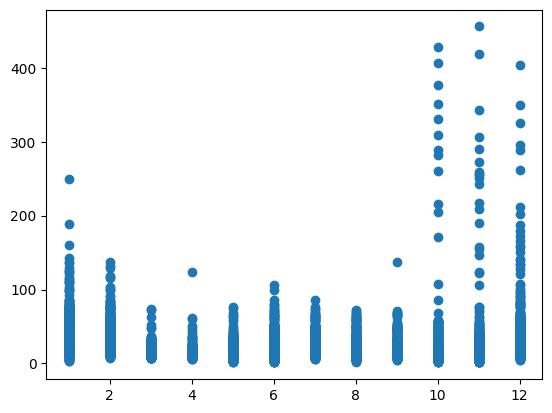

In [10]:
# now i have encoded the columns 
# let's do some visualisations 

plt.scatter(data=df, x="month", y="pm2_5");

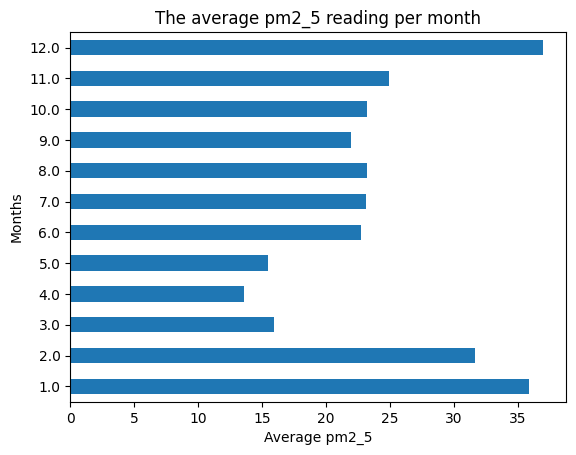

In [11]:
df.groupby("month")["pm2_5"].mean().plot(kind="barh")
plt.title("The average pm2_5 reading per month")
plt.xlabel("Average pm2_5")
plt.ylabel("Months");

The above chart shows that month will be a good feature in predicting for the pm2_5

<Axes: ylabel='date'>

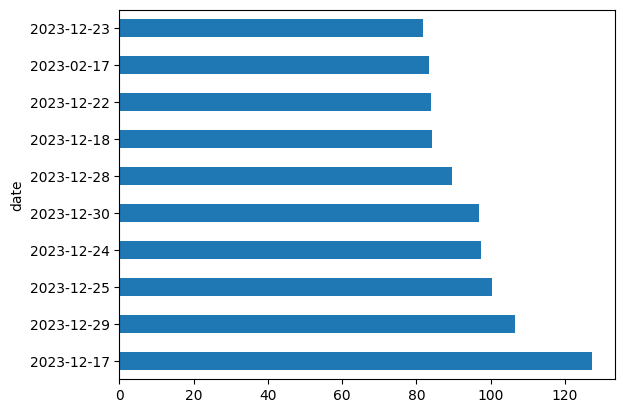

In [12]:
# let's check the date column 
df.groupby("date")["pm2_5"].mean().sort_values(ascending=False).head(10).plot(kind="barh")

Date also promised to be useful in predicting the pm2_5 reading 

<Axes: ylabel='city'>

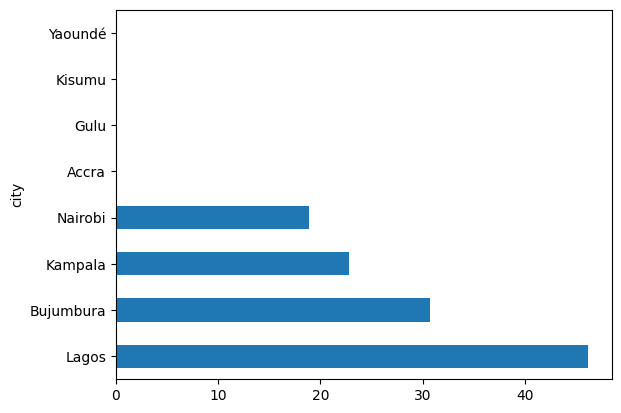

In [13]:
df.groupby("city")["pm2_5"].mean().sort_values(ascending=False).head(10).plot(kind="barh")

In [14]:
# split the data into the training set and the test set 

train = df[df["train"] == 1]
test = df[df["train"] == 0]

train = train.drop(columns="train")
test = test.drop(columns=["train", "pm2_5"])

In [15]:
# create the features  and the target 
features = numeric_cols + cat_cols
target = "pm2_5"
len(features)

23

In [16]:
# this does not work as expected so i need to use target encoding 

In [17]:
encoder = TargetEncoder()

In [18]:
# Fit and transform on training data
train[cat_cols] = encoder.fit_transform(train[cat_cols], train[target])

# Transform Test set 
test[cat_cols] = encoder.transform(test[cat_cols])

In [19]:
len(train[numeric_cols + cat_cols].select_dtypes(np.number).columns.tolist())

23

Now I have done the target encoding. Let me train the model 

In [20]:
# split the training set into two to evaluate the model 


In [21]:
model = make_pipeline(
    SimpleImputer(strategy="most_frequent"), 
    MinMaxScaler(), 
    Ridge()
)

In [22]:
train_new, first_test = train_test_split(train, test_size=0.3, random_state=42)

In [23]:
train_new.shape, first_test.shape

((5649, 24), (2422, 24))

In [24]:
X_train = train_new[numeric_cols + cat_cols]
y_train = train_new[target]

X_test_1 = first_test[numeric_cols + cat_cols]
y_test_1 = first_test[target]

X_test_2 = test[numeric_cols + cat_cols]


In [25]:
# feeding the training set into the model 
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('minmaxscaler', MinMaxScaler()), ('ridge', Ridge())])

In [26]:
model.score(X_train, y_train)

0.6358213248713663

In [27]:
preds = model.predict(X_test_1)

In [28]:
np.sqrt(mean_absolute_error(model.predict(X_train), y_train))

2.79756021933797

In [29]:
np.sqrt(mean_absolute_error(preds, y_test_1))

2.790840943518543

In [30]:
# now lets make submission predictions 
sub_preds = model.predict(X_test_2)

In [31]:
submit = {
    "id": X_test_2.index, 
    "pm2_5": sub_preds
}

In [32]:
submission_df = pd.DataFrame(submit)

In [33]:
submission_df.to_csv("submission1.csv", index=False)

In [34]:
models = [
    LinearRegression(), 
    Ridge(), 
    Lasso(),
    ElasticNet(), 
    SVR(),
    DecisionTreeRegressor(), 
    RandomForestRegressor(), 
    LGBMRegressor(), 
    GradientBoostingRegressor()
]

def get_best_model(models): 
    
    best_model = None
    best_mse = float("inf")

    for model in models: 
        model_pipleline = make_pipeline(
            
          SimpleImputer(strategy="most_frequent"), 
          MinMaxScaler(), 
          model 
        )

        model_pipleline.fit(X_train, y_train)

        pred_for_model = model_pipleline.predict(X_test_1)
        mse = np.sqrt(mean_absolute_error(y_test_1, pred_for_model))

        if mse < best_mse: 
            best_mse = mse 
            best_model = model 
    return {"best_mse": best_mse, 
            "best_model": best_model
           }

In [35]:
get_best_model(models)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4296
[LightGBM] [Info] Number of data points in the train set: 5649, number of used features: 23
[LightGBM] [Info] Start training from score 24.568926


{'best_mse': 2.4172827399674475, 'best_model': RandomForestRegressor()}

In [47]:
# create the parameter grid 
param_grid = {
    'imputer__strategy': ['mean', 'median'],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__bootstrap': [True, False],
    # 'rf__criterion': ['mse', 'mae']
}


In [48]:
def rmse(y_pred, y_true): 
    return mean_squared_error(y_pred, y_true, squared=False)

scoring = make_scorer(
    rmse, 
    greater_is_better=False   
)

In [49]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    ("scaler", MinMaxScaler()), 
    ("rf", RandomForestRegressor())
])

In [ ]:
grid_search = GridSearchCV(
    pipeline, 
    param_grid=param_grid, 
    cv=5, 
    scoring=scoring, 
    verbose=1, 
    n_jobs=-1
)

In [ ]:
# there is a problem with the ggrid_search because of nan values 

In [ ]:
# the pipeline is not working as expected, Ill need to do manual imputation for the nan values before feeding into ggrid_search

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
